# MCMC 2.1: application for parameter estimation

In this notebook, we will use a Markov Chain based on the Metropolis-Hastings algorithm to estimate neutrino oscillation parameters.

The experiment setup simulated in this notebook is the one of the Deep Underground Neutrino Experiment (DUNE). DUNE measures neutrino oscillations by observing the transition of a muon (anti)neutrino beam created in Fermilab toward electron and tau (antineutrinos) in the far detector located 1'300 km away, in the Sanford Underground Research Facility. 

In [1]:
### Import necessary python packages

# math package
import numpy as np
import scipy.stats
import time

# plotting packages
import matplotlib as mpl
from matplotlib import pyplot as plt

# input files reading package 
import json

# data container package
import pandas as pd

# get the time
from datetime import datetime


In [2]:
### Setup plot options

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


## 1. Obtain the neutrino flux

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [3]:
### Function to read a JSON with several dictionaries separated by a new line

def json_reader(filename):
    with open(filename) as f:
        for line in f:
            yield json.loads(line)


In [4]:
### Read JSON file

flux_file = "dune_flux_hist.json"

flux_data = list(json_reader(flux_file))
len(flux_data), flux_data[0].keys()


(144,
 dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title']))

### 1.1 Unoscillated event rate

The input is the charged-current event rate of neutrino interactions in the DUNE far detector. The event rate has been obtained from the ancillary files published at: https://arxiv.org/abs/2103.04797

In [5]:
### Select dictionary for FD, neutrino mode, muon neutrino unoscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = ''

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_unosc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_unosc = flux_data_numode_fd_numu_ccrate_unosc[0]
evt_rate_unosc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

In [6]:
### Select dictionary for FD, neutrino mode, muon neutrino oscillated event rate

config = 'flux_dune_neutrino_FD'
nu_type = 'numu'
flux_type = 'cceventrate'
osc = 'osc'

flux_data_numode_fd = [f for f in flux_data if f['config'] == config]
flux_data_numode_fd_numu = [f for f in flux_data_numode_fd if f['nu'] == nu_type]
flux_data_numode_fd_numu_ccrate = [f for f in flux_data_numode_fd_numu if f['flux'] == flux_type]
flux_data_numode_fd_numu_ccrate_osc = [f for f in flux_data_numode_fd_numu_ccrate if f['osc'] == osc]

evt_rate_osc = flux_data_numode_fd_numu_ccrate_osc[0]
evt_rate_osc.keys()

dict_keys(['file', 'config', 'nu', 'flux', 'osc', 'bins', 'counts', 'xaxis_title', 'yaxis_title'])

### 1.2 Oscillated event rate

We will use as model the simplified case of 2 neutrino flavours, the neutrino oscillation "appearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_e} \ = \ \sin^2 (2\theta) \ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) $$
with: 
$$ \sin^2 \left( \frac{\Delta m^2 L}{4E} \right) \ \simeq \ \sin^2 \left( 1.27 \frac{\Delta m^2 [eV^2] \ L[km]}{E[GeV]} \right) $$
so the "disappearance" probability is: 
$$ P_{\nu_{\mu} \rightarrow \nu_{\mu}} \ = 1 - P_{\nu_{\mu} \rightarrow \nu_e} $$

The oscillation parameters are the mixing angle $\theta$ and the square of mass difference $\Delta m^2$. We want to estimate them using the histograms that we extracted.

In [7]:
### Define the oscillation probability

def osc_proba(E, theta=np.pi/4, Dm2=2.2e-3, L=1300):
    sin1 = np.sin(2*theta)**2
    sin2 = np.sin(1.27 * Dm2 * L / E)**2
    return 1 - sin1 * sin2

In [8]:
### Function to apply the oscillation to the unoscillated histogram 

def compute_osc_histo(theta, Dm2, hist): 

    # we will take the energy at the bin center
    bin_centers = []
    evt_rate_osc = [0]

    # loop over bins
    for i_b in np.arange(1, len(hist['bins'])):
        bin_centers.append(hist['bins'][i_b] - ((hist['bins'][i_b] - hist['bins'][i_b-1])/2))
        evt_rate_osc.append(hist['counts'][i_b] * 20*1.47e21* osc_proba(bin_centers[-1], theta, Dm2))
    
    return evt_rate_osc

In [9]:
### Apply the oscillation to the unoscillated histogram and plot at the result

theta_true = np.pi/4
Dm2_true = 2.2e-3

evt_rate_osc_true = compute_osc_histo(theta_true, Dm2_true, evt_rate_unosc)


### 1.3 Compare the event rates

We will now compare the unoscillated and oscillated event rate. 

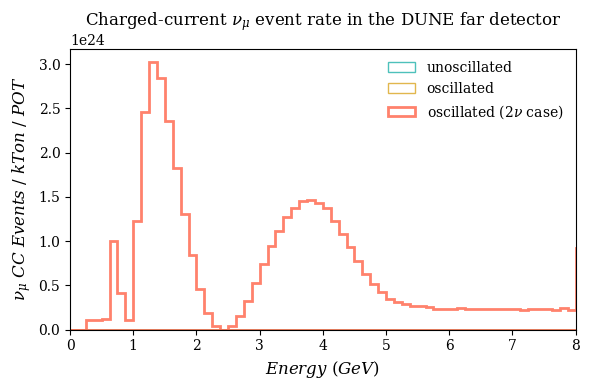

In [10]:
### Plot the fluxes

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(6,4), tight_layout=True)

# unoscillated rate from the DUNE ancillary file
ax.hist(evt_rate_unosc['bins'][:-1], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_unosc['counts'][:-1]],
        color=None, edgecolor='lightseagreen', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'unoscillated')

# oscillated rate from the DUNE ancillary file
ax.hist(evt_rate_osc['bins'][:-1], bins=evt_rate_osc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc['counts'][:-1]],
        color=None, edgecolor='goldenrod', fill=False, lw=1, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= 'oscillated')

# oscillated rate computed with the 2-neutrino formula
ax.hist(evt_rate_unosc['bins'], bins=evt_rate_unosc['bins'], weights=[rate * 20 * 1.47e21 for rate in evt_rate_osc_true],
        color=None, edgecolor='tomato', fill=False, lw=2, ls = '-', 
        histtype= "stepfilled", alpha= 0.8, label= r'oscillated (2$\nu$ case)')

# title and axes
ax.set_title(r'Charged-current $\nu_{\mu}$ event rate in the DUNE far detector')
ax.set_xlim([0, 8])
ax.set_xlabel(r'$' + evt_rate_unosc['xaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
ax.set_ylabel(r'$' + evt_rate_unosc['yaxis_title'].replace('#', '\\').replace(' ', ' \ ') +'$', fontsize=12)
ax.legend(frameon=False)


## 2. Set up the Markov Chain

We will use a Markov Chain to sample the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC process at each step is: 
- throw a value of $\theta$ and $\Delta m^2$: $\{\theta_i, \Delta m^2_i \}$
- compute the oscillation probability for those parameter value at the DUNE energy $E_j$: $P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j)$
- apply the oscillation probability to the unoscillated histogram: $ N_{osc(i)}(E_j) =  N_{unosc}(E_j) \times P_{\nu_{\mu} \rightarrow \nu_e}(\theta_i, \Delta m^2_i, E_j ) $
- compute the likelihood between the generated oscillated histogram and the one extracted from the file: 
- compute the Metropolis-Hastings ratio $r_i$ between the likelihood at this step and the likelihood at the previous step
- apply the acceptance function $A_i$
- redo until reaching the desired number of steps

### 2.1 Define the target distribution

The target distribution is the posterior probability of the $\theta$ and $\Delta m^2$ parameters. The MCMC will sample:  
$$ P(\theta, \Delta m^2 | \vec{D}) = P(\vec{D} | \theta, \Delta m^2) \ P(\theta, \Delta m^2) $$
where 
- $ P(\theta, \Delta m^2 | \vec{D}) $ is the posterior probability 
- $ P(\vec{D} | \theta, \Delta m^2) $ is the likelihood 
- $P(\theta, \Delta m^2)$ is the prior probability on the parameters $\theta$ and  $\Delta m^2$ 

**2.1.1 Prior probability**

We use a uniform prior probability on $\theta$ and $\Delta m^2$: 
$$ P(\theta) = \sqcap(-\pi/2, \pi/2) $$
$$ P(\Delta m^2) = \sqcap(0, 0.01) $$

defined as: 
- $P(\theta) = 1$ if $\theta \in [-\pi/2, \pi/2]$
- $P(\Delta m^2) = 1$ if $\Delta m^2 \in [0, 10^{-2}]$
- $P(\theta, \Delta m^2) = 0$ elsewehere


In [11]:
### Prior on theta


In [12]:
### Prior on Dm2


**2.1.2 Likelihood function**

As we compare histogram, we use $\mathcal{L}_i = exp(\ln(\mathcal{L}_i)) $ where $\ln(\mathcal{L}_i)$ is the log-likelihood ratio: 
$$-\ln(\mathcal{L}_i) = \sum_{j=1}^{N \ bins} N^H_{i,j}(\theta_i, \Delta m^2_i) -  N^D_{i,j} + N^D_{i,j} \ ln \left( \frac{N^D_{i,j}}{N^H_{i,j}(
\theta_i, \Delta m^2_i)} \right) $$

with $N^D_{i,j}$ the number of event in each bin $j$ of the true histogram, and $N^H_{i,j}(\theta_i, \Delta m^2_i)$ the number of event in each bin $j$  of the computed histogram at this step $i$ 

In [13]:
### Compute the likelihood
def likelihood(data):
    ln_L = 0
    for i in range(len(data)):
        if data[i] != 0 and evt_rate_osc_true[i] != 0:
            ln_L += data[i] - evt_rate_osc_true[i] + evt_rate_osc_true[i] * np.log(evt_rate_osc_true[i] / data[i])
    return -ln_L

Dans $data$ se trouve le résultat de $compute-osc-histo$

In [14]:
theta = np.linspace(0, np.pi/2, 400)
Dm2 = np.linspace(0,0.01, 400)
dim = 2

def likelihood_wrapper(theta_val, Dm2_val):
    return likelihood(compute_osc_histo(theta_val, Dm2_val, evt_rate_unosc))

vectorized_likelihood = np.vectorize(likelihood_wrapper)

theta_grid, Dm2_grid = np.meshgrid(theta, Dm2)

grid_likelihood = vectorized_likelihood(theta_grid, Dm2_grid)

In [15]:
#likelihood(compute_osc_histo(1.5, 5e-3, evt_rate_unosc))

# On obtient 2509.07 avec les deux likelihood

[[1.10197248e+00 7.09134359e-03]
 [1.38468773e+00 6.50694639e-03]
 [3.76624436e-02 1.10321754e-03]
 [2.37367376e-01 4.18435783e-03]
 [3.91850751e-01 1.41269060e-03]
 [3.44850347e-01 2.57959103e-03]
 [8.38471399e-01 1.00734928e-03]
 [3.31374743e-01 6.06476308e-03]
 [1.02661966e+00 2.27781998e-03]
 [1.16975451e+00 5.65147365e-03]
 [4.61812124e-01 2.84924343e-03]
 [1.44036503e-01 9.74197682e-03]
 [1.02088677e+00 6.12064480e-03]
 [1.46670355e+00 5.21482631e-03]
 [2.31140807e-01 6.57546264e-03]
 [2.73866441e-01 8.58012821e-03]
 [4.12831118e-01 4.78510825e-03]
 [1.23630585e+00 2.19249040e-03]
 [7.43881250e-01 4.51970895e-04]
 [3.34011272e-02 5.11552473e-03]
 [4.43876378e-01 5.10148077e-03]
 [1.07854967e+00 6.44777437e-03]
 [1.43092058e+00 3.10201057e-03]
 [1.12937854e-01 5.05852557e-04]
 [1.37000536e+00 5.89933970e-04]
 [7.06017900e-01 6.13768811e-03]
 [1.01316975e+00 8.84941396e-03]
 [5.81771523e-01 6.33344078e-03]
 [5.02200183e-01 1.03390196e-03]
 [1.18134098e+00 1.79690159e-03]
 [5.224954

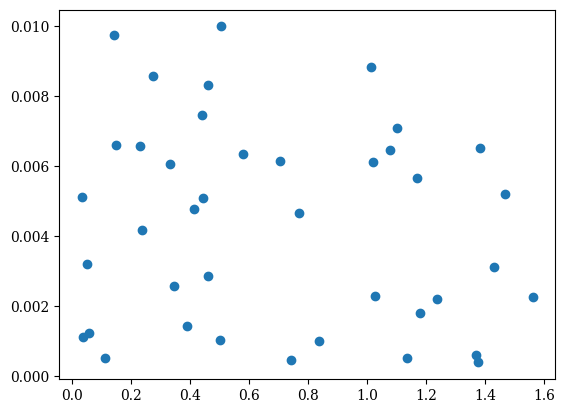

In [16]:
N_live = 40
dim = 2

live_points = np.random.uniform([n for n in (0,0)], [m for m in (np.pi/2, 0.01)], size = (N_live, dim))

live_points_likelihood = np.vectorize(likelihood_wrapper)(live_points[:,0], live_points[:,1])

print(live_points)

plt.scatter(live_points[:,0], live_points[:,1]);

In [17]:
V = 1
ordre = np.argsort(abs(live_points_likelihood))
print(abs(live_points_likelihood))
print(ordre)

[1619.66897084 2330.79301307 2530.76883226 2169.05883906 1585.7764702
 1366.8979619  2098.26158539 2017.06998946  358.15391296 1884.91057578
  926.50082763 2373.0377275  1730.84454085 2475.54043642 2227.26308904
 2004.55692436 1852.67231045 1397.66322353 2261.18593249 2532.78417488
 1836.8453418  1695.83596139 2334.82411222 2515.32246538 2447.13024444
 2058.94798199 1528.99599231 1718.19741625 1749.26045447 1282.79956335
 2510.98888896 1577.51432455 2515.37282337 1629.64623401 1511.20545354
 2497.01389741 2469.2244154  2400.3164975  2286.19148831 2538.51265194]
[ 8 10 29  5 17 34 26 31  4  0 33 21 27 12 28 20 16  9 15  7 25  6  3 14
 18 38  1 22 11 37 24 36 13 35 30 23 32  2 19 39]


In [18]:
volume_shell = np.random.beta(1,N_live)
volume_shell

0.015518997961589147

In [19]:
V *= 1 - volume_shell
V

0.9844810020384108

39
8
1.5615908385923223 0.002245926137349282
1.0266196550613094 0.0022778199792614228
Likelihood pire -2538.5126519410423
Likelihood best -358.1539129551621


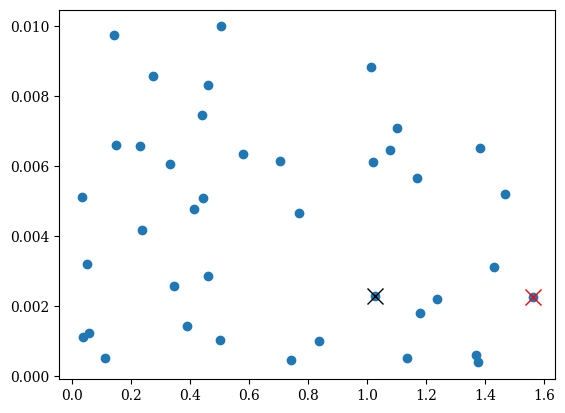

In [20]:
pire = np.argmin(live_points_likelihood)
best = np.argmax(live_points_likelihood)
print(pire)
print(best)
print(live_points[pire,0], live_points[pire,1])
print(live_points[best,0], live_points[best,1])
L_min = live_points_likelihood[best]
print("Likelihood pire", live_points_likelihood[pire])
print("Likelihood best", live_points_likelihood[best])

plt.scatter(live_points[:,0], live_points[:,1])
plt.plot(live_points[pire,0], live_points[pire,1], 'x', color='r', ms=12);
plt.plot(live_points[best,0], live_points[best,1], 'x', color='black', ms=12);

In [21]:
morts = [live_points[pire].copy()]
morts_likelihood = [L_min]
morts_volume = volume_shell

In [22]:
def likelihood_reject(L_min, volume_bounds, max_tries=100000):
    dim = 2
    for _ in range(max_tries):
        proposed_point = np.random.uniform([0.76, 2.19e-3], [0.8, 2.21e-3], size=dim)
        proposed_likelihood = likelihood_wrapper(*proposed_point)
        
        if proposed_likelihood > L_min:
            return proposed_point, proposed_likelihood
    
    return None

def likelihood_reject(L_min, volume_bounds):
    proposed_points = np.random.uniform([m for m in (0.7, 2.1e-3)], [n for n in (0.9, 2.3e-3)], size=(10000, dim)) 
    proposed_points_likelihood = np.vectorize(likelihood_wrapper)(proposed_points[:,0], proposed_points[:,1])
    if (proposed_points_likelihood > L_min).any():
        i = np.where(proposed_points_likelihood > L_min)[0][0]
        return proposed_points[i,:], proposed_points_likelihood[i]
    elif proposed_points == None:
        proposed_points = np.random.uniform([n for n in volume_bounds[0]], [m for m in volume_bounds[1]], size=(10000, dim)) 

In [23]:
#live_points[pire], live_points_likelihood[pire] = likelihood_reject(L_min)

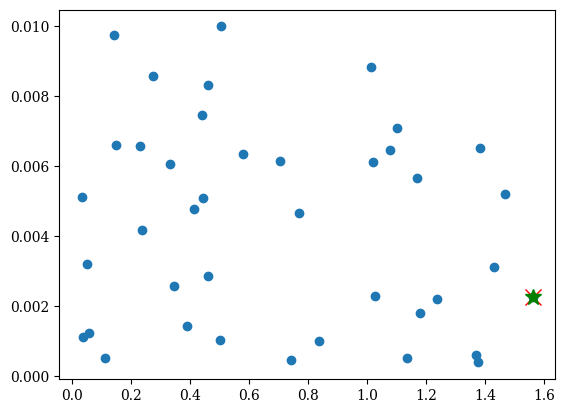

In [24]:
plt.scatter(live_points[:,0], live_points[:,1])
plt.plot(morts[0][0], morts[0][1], 'x', color='r', ms=12)
plt.plot(live_points[pire,0], live_points[pire,1], '*', color='g', ms=12);

In [25]:
def nested_sampling_test(iterations, N_live):
    volume = 1

    live_points = np.random.uniform([m for m in (0.76, 2.19e-3)], [n for n in (0.8, 2.21e-3)], size=(N_live, dim))
    live_points_likelihood = np.vectorize(likelihood_wrapper)(live_points[:,0], live_points[:,1])
    #live_points_likelihood = abs(live_points_likelihood)
    plt.scatter(live_points[:,0], live_points[:,1])
    #print(live_points)
    
    morts = []
    morts_likelihood = []
    morts_volume = []
    volume_restant = []
    comptage = [0]

    for i in range(iterations):

        L_min = live_points_likelihood.min()
        pire = np.argmin(live_points_likelihood)
        #print("pire :", pire, "parmis :", live_points_likelihood)

        volume_shell_fraction = np.random.beta(1, N_live)
        volume_shell = volume * volume_shell_fraction
        volume *= 1 - volume_shell_fraction

        morts.append(live_points[pire].copy())
        morts_likelihood.append(np.copy(L_min))
        morts_volume.append(volume_shell)
        volume_restant.append(volume)

        volume_bounds = ([0, 0], [np.pi/2*volume, 0.01 * volume])

        point_de_remplacement = likelihood_reject(L_min, volume_bounds)
        if point_de_remplacement is None:
                break
        
        live_points[pire], live_points_likelihood[pire] = point_de_remplacement
        comptage.append(i)
    return morts, morts_likelihood, morts_volume, volume_restant, comptage

--- 1752.7827861309052 seconds ---


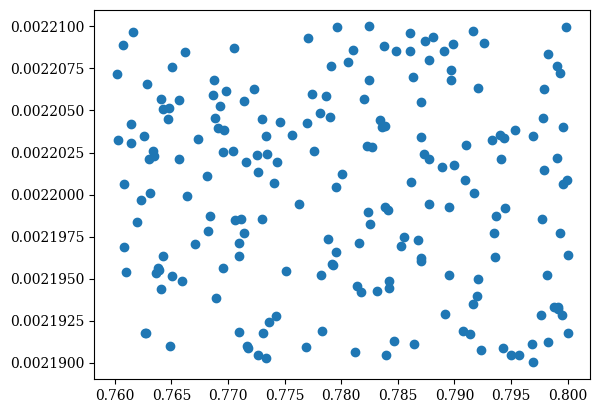

In [26]:
iterations = 10000
start_time = time.time()
morts, morts_likelihood, morts_volume, volume_restant, comptage = nested_sampling_test(iterations, 200)
print("--- %s seconds ---" % (time.time() - start_time))


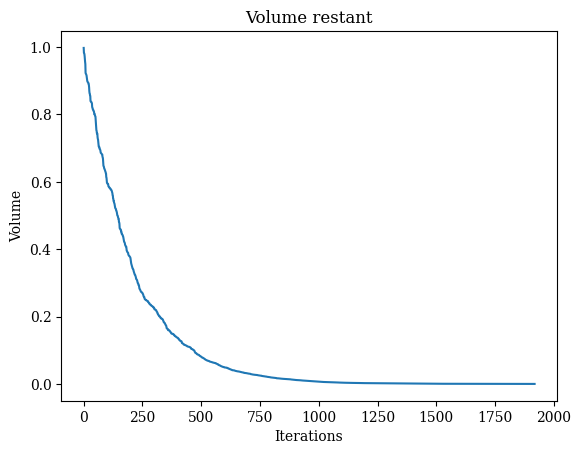

In [27]:
plt.plot(volume_restant)
plt.title("Volume restant")
plt.xlabel("Iterations")
plt.ylabel("Volume");


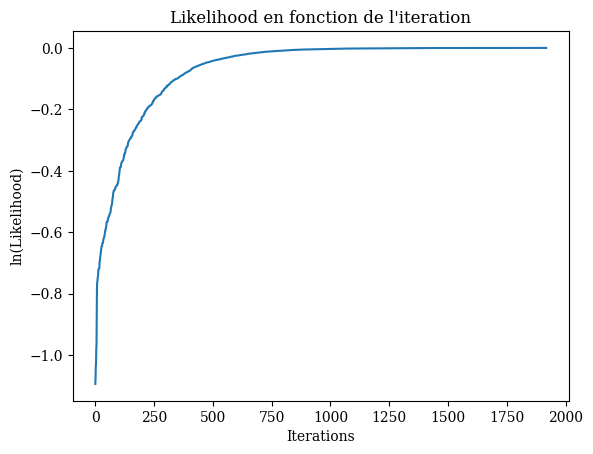

In [28]:
plt.plot(morts_likelihood)
plt.title("Likelihood en fonction de l'iteration")
plt.xlabel('Iterations')
plt.ylabel('ln(Likelihood)');

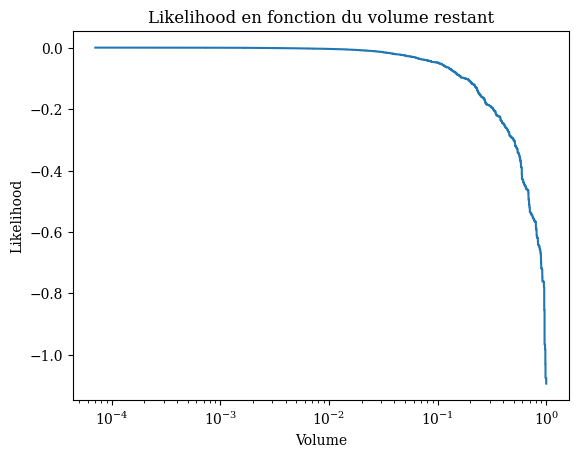

In [29]:
plt.plot(volume_restant, morts_likelihood, '-', drawstyle = 'steps-pre')
plt.xscale('log')
plt.title("Likelihood en fonction du volume restant")
plt.ylabel("Likelihood")
plt.xlabel("Volume");

In [30]:
#Pour ne pas avoir des erreurs de calculs
max_likelihood = np.max(morts_likelihood)
shifted_likelihood = morts_likelihood - max_likelihood


Z = (morts_volume * np.exp(shifted_likelihood)).sum()


print("L'évidence est :", Z)

L'évidence est : 0.7190667141299579


In [31]:
morts_poids = morts_volume * np.exp(shifted_likelihood) / Z
#print(np.exp(shifted_likelihood))
#print(morts_poids)

In [32]:
Z

0.7190667141299579

Text(0, 0.5, 'Poids du sample')

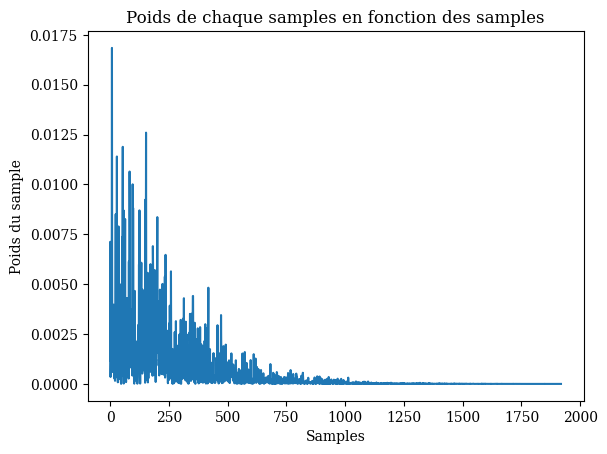

In [33]:
plt.plot(morts_poids)
plt.title("Poids de chaque samples en fonction des samples")
plt.xlabel('Samples')
plt.ylabel("Poids du sample")

#plt.axis([5000, 5200, 0, 0.006])

In [34]:
def effective_sample_size(importance_weights):
    return int(len(importance_weights) / (1 + (importance_weights / importance_weights.mean() - 1)**2).mean() )

In [35]:
indices = np.random.choice(len(morts_poids), p = morts_poids, size=int(20000))
samples_posterior = np.asarray(morts)[indices]

In [36]:
len(set(indices))

993

[[0.78254262 0.00220313]
 [0.79675112 0.00219762]
 [0.76695261 0.00220056]
 ...
 [0.79247909 0.00220327]
 [0.76329399 0.00220159]
 [0.77959374 0.00220997]]


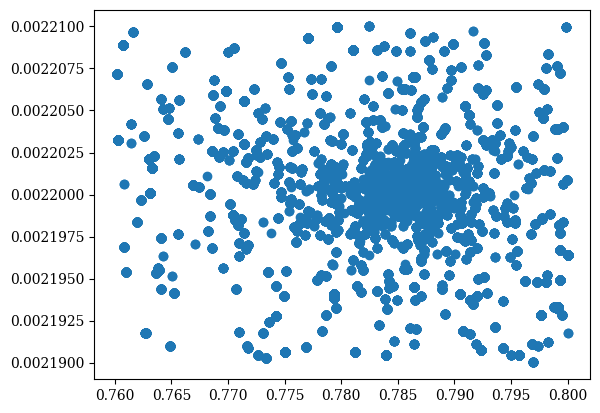

In [37]:
plt.scatter(samples_posterior[:,0], samples_posterior[:,1]);
print(samples_posterior)

In [38]:
#print(samples_posterior[:,0])
#print(samples_posterior[:,1])

In [39]:
np.mean(samples_posterior[:,0])

0.7820287776879389

In [40]:
np.mean(samples_posterior[:,1])

0.0021997465384868617

1919


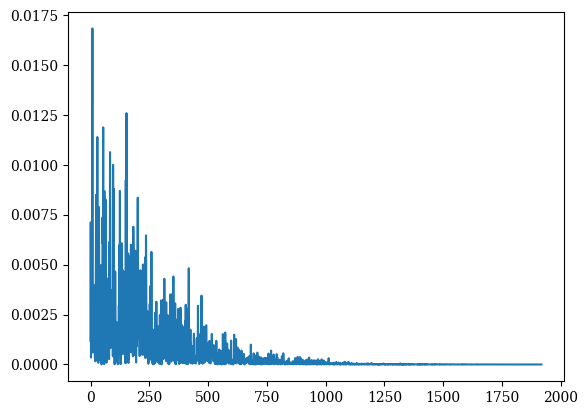

In [41]:
plt.plot(morts_poids)
print(len(morts_poids))

In [42]:
morts_poids = np.asarray(morts_poids)[indices]

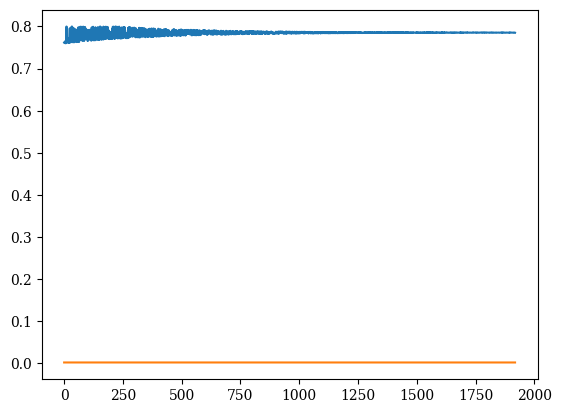

In [43]:
plt.plot(morts)

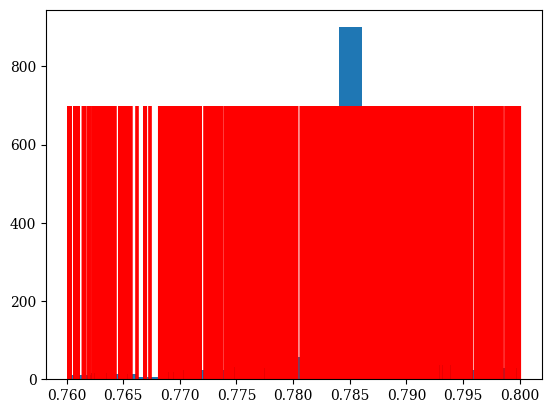

In [44]:
plt.hist([m[0] for m in morts], bins = 20)
plt.vlines(samples_posterior[:,0], 0, 700, color ='r')

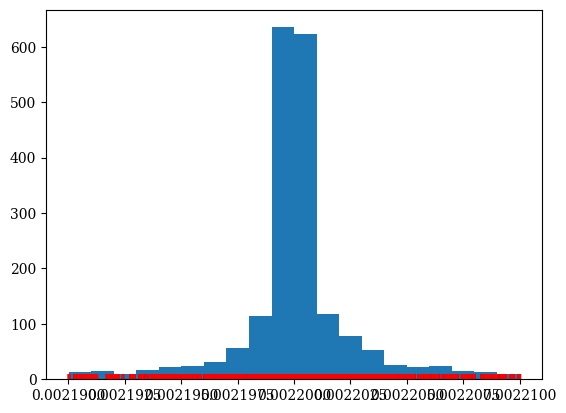

In [45]:
plt.hist([m[1] for m in morts], bins = 20)
plt.vlines(samples_posterior[:,1], 0, 10, color ='r')

In [46]:
np.savetxt('morts.csv', (morts), delimiter=',')


In [47]:
likelihood_posterior = np.asarray(morts_likelihood)[indices]

Text(0.5, 0, 'theta')

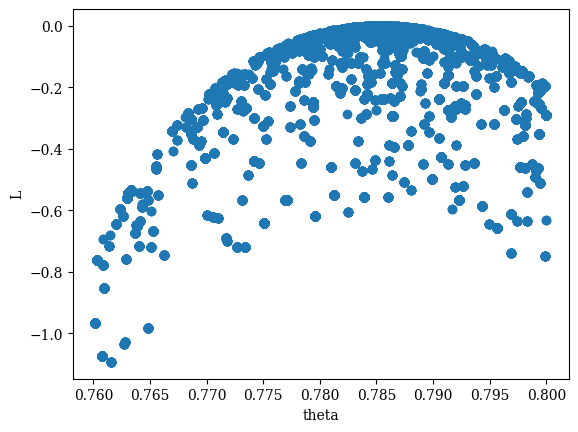

In [48]:
plt.scatter(samples_posterior[:,0], likelihood_posterior)
#plt.scatter(samples_posterior[:,1], likelihood_posterior)
plt.ylabel('L')
plt.xlabel('theta')

Text(0.5, 0, 'dm2')

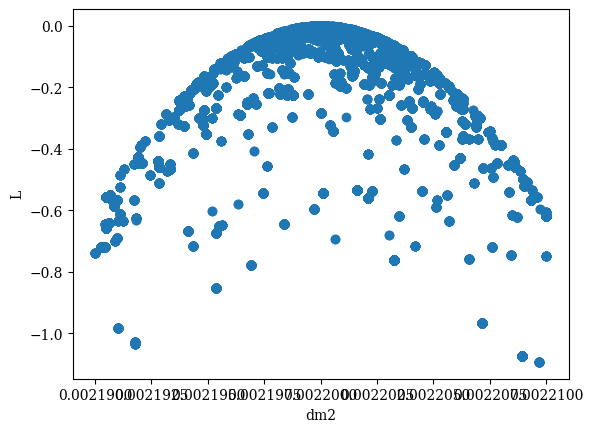

In [49]:
plt.scatter(samples_posterior[:,1], likelihood_posterior)
plt.ylabel('L')
plt.xlabel('dm2')

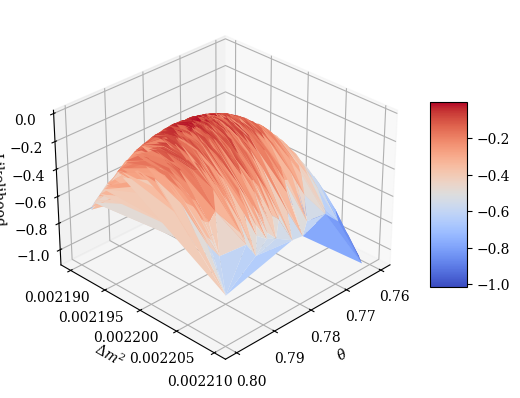

In [50]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Créer la grille pour les axes X et Y
X, Y = np.meshgrid(samples_posterior[:,0], samples_posterior[:,1])

# Mettre à l'échelle likelihood_posterior pour une meilleure visualisation

# Tracer la surface 3D
surf = ax.plot_trisurf(samples_posterior[:,0], samples_posterior[:,1], likelihood_posterior, 
                       cmap=cm.coolwarm, linewidth=0, antialiased=True)

# Ajouter un colorbar pour la carte de couleurs
fig.colorbar(surf, shrink=0.5, aspect=5)

# Ajuster la vue
ax.view_init(30, 45)

# Ajouter des labels
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\Delta m^2$')
ax.set_zlabel('Likelihood')

plt.show()

In [51]:
np.savetxt('data_haut_morts_new_new.csv', (morts), delimiter=',')
np.savetxt('data_haut_morts_poids_new_new.csv', (morts_poids), delimiter=',')
np.savetxt('data_haut_samples_posterior_new_new.csv', (samples_posterior), delimiter=',')
np.savetxt('data_haut_likelihood_posterior_new_new.csv', (likelihood_posterior), delimiter=',')
np.savetxt('data_haut_morts_likelihood_new_new.csv', (morts_likelihood), delimiter='-')
np.savetxt('data_haut_morts_volume_new_new.csv', (morts_volume), delimiter ='-')
np.savetxt('data_haut_comptage_new_new.csv', (comptage), delimiter ='-')

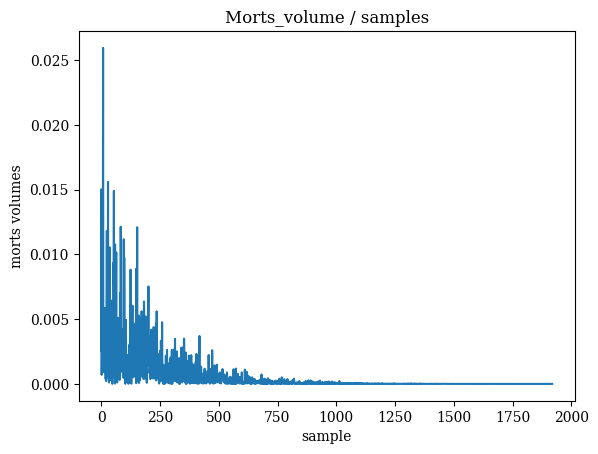

In [52]:
plt.plot(morts_volume)
plt.title('Morts_volume / samples');
plt.xlabel('sample')
plt.ylabel('morts volumes');

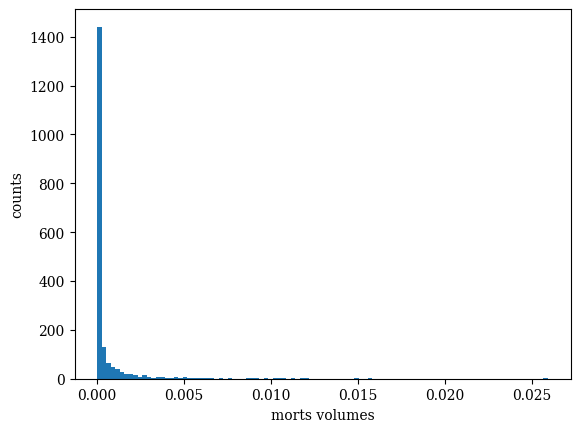

In [53]:
plt.hist(morts_volume, bins = 100);
plt.xlabel('morts volumes')
plt.ylabel('counts');

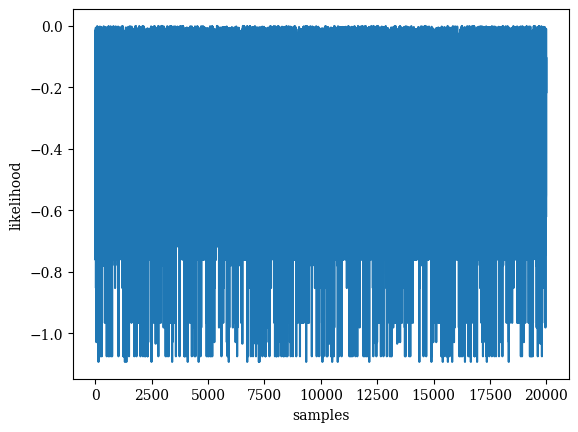

In [54]:
plt.plot(likelihood_posterior)
plt.xlabel('samples')
plt.ylabel('likelihood');

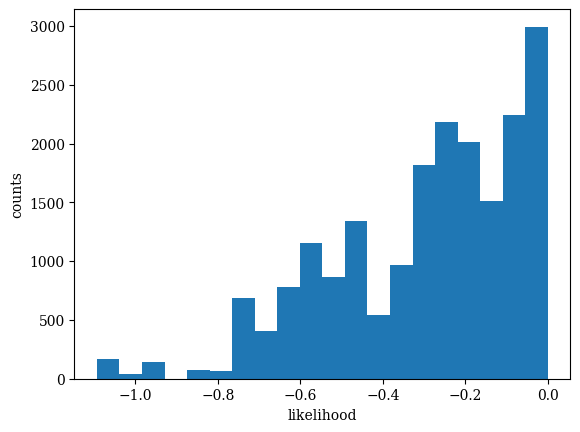

In [55]:
plt.hist(likelihood_posterior, bins = 20);
plt.xlabel('likelihood')
plt.ylabel('counts');

In [56]:
test = []
test = np.quantile(likelihood_posterior, [0.05, 0.95], axis=0)
print(test)

[-0.72076552 -0.01722339]


In [57]:
quantiles = np.quantile(likelihood_posterior, [0.05, 0.95])

# Indices des lignes de samples_posterior correspondant aux quantiles
idx_5 = np.where(likelihood_posterior <= quantiles[0])[0]
idx_95 = np.where(likelihood_posterior >= quantiles[1])[0]

# Valeurs de samples_posterior correspondant aux quantiles 5% et 95%
samples_5 = samples_posterior[idx_5]
samples_95 = samples_posterior[idx_95]


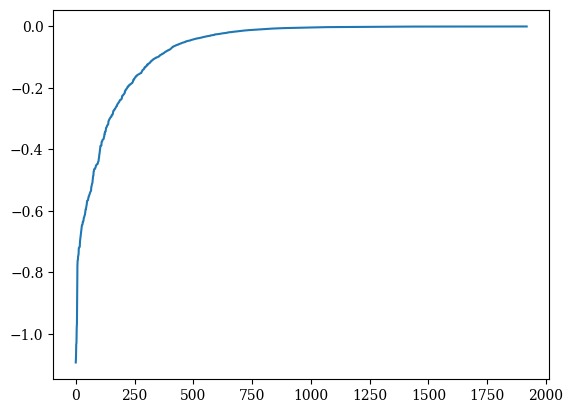

In [58]:
plt.plot(morts_likelihood)